In [36]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from xgboost import XGBRegressor
import xgboost as xgb
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

In [2]:
df = pd.read_csv("doordash.csv")

In [3]:
df

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2/6/2015 22:24,2/6/2015 23:27,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2/10/2015 21:49,2/10/2015 22:56,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,1/22/2015 20:39,1/22/2015 21:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2/3/2015 21:21,2/3/2015 22:13,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2/15/2015 2:40,2/15/2015 3:20,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2/17/2015 0:19,2/17/2015 1:24,2956,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0,251,331.0
197424,1.0,2/13/2015 0:01,2/13/2015 0:58,2956,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0,251,915.0
197425,1.0,1/24/2015 4:46,1/24/2015 5:36,2956,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0,251,795.0
197426,1.0,2/1/2015 18:18,2/1/2015 19:23,3630,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0,446,384.0


In [4]:
df.isna().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [5]:
#If actual_delivery_time is missing, you can’t compute the delivery duration, making the row unusable for supervised learning.

critical_columns = [
    'market_id',
    'actual_delivery_time'
]

# Removing rows with null values in the above mentioned attributes or columns
df = df.dropna(subset=critical_columns)

In [6]:
def handle_null_values(df):
    # Safely fill nulls by reassigning columns directly (no inplace)
    
    df['store_primary_category'] = df['store_primary_category'].fillna('Uncategorized')
    
    df['order_protocol'] = df['order_protocol'].fillna(df['order_protocol'].mode()[0])
    
    df['estimated_store_to_consumer_driving_duration'] = df['estimated_store_to_consumer_driving_duration'].fillna(
        df['estimated_store_to_consumer_driving_duration'].median()
    )
    
    return df

# Make sure to copy df beforehand if it's coming from a slice
df = df.copy()

# Apply the safe function
df = handle_null_values(df)


In [7]:
#The price_range feature was engineered to capture the spread between the most and least expensive items in an order, serving as a proxy for order complexity and its potential impact on delivery time.
df['price_range'] = df['max_item_price'] - df['min_item_price']


In [8]:
df['total_onshift_dashers'] = df['total_onshift_dashers'].fillna(df['total_onshift_dashers'].mean())
df['total_busy_dashers'] = df['total_busy_dashers'].fillna(df['total_busy_dashers'].mean())
df['total_outstanding_orders'] = df['total_outstanding_orders'].fillna(df['total_outstanding_orders'].mean())

In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

data = df.copy()

# Convert timestamps
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])

# Extract time-based features
data['hour_of_day'] = data['created_at'].dt.hour
data['day_of_week'] = data['created_at'].dt.dayofweek
data['month'] = data['created_at'].dt.month

# Compute the delivery duration in minutes
data['delivery_duration_minutes'] = (
    (data['actual_delivery_time'] - data['created_at']).dt.total_seconds() / 60
)

# Encode categorical variables
te = TargetEncoder()
data['store_primary_category_encoded'] = te.fit_transform(data['store_primary_category'], data['delivery_duration_minutes'])
data['store_id'] = data['store_id'].astype(str)
data['store_id_encoded'] = te.fit_transform(data['store_id'], data['delivery_duration_minutes'])
data = pd.get_dummies(data, columns=['market_id', 'order_protocol'], drop_first=True)

In [10]:
data.columns
data

,created_at,actual_delivery_time,store_id,store_primary_category,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,...,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,2015-02-06 22:24:00,2015-02-06 23:27:00,1845,american,4,3441,4,557,1239,33.0,...,False,False,False,False,False,False,False,False,False,False
1,2015-02-10 21:49:00,2015-02-10 22:56:00,5477,mexican,1,1900,1,1400,1400,1.0,...,False,False,False,False,True,False,False,False,False,False
2,2015-01-22 20:39:00,2015-01-22 21:09:00,5477,Uncategorized,1,1900,1,1900,1900,1.0,...,True,False,False,False,False,False,False,False,False,False
3,2015-02-03 21:21:00,2015-02-03 22:13:00,5477,Uncategorized,6,6900,5,600,1800,1.0,...,True,False,False,False,False,False,False,False,False,False
4,2015-02-15 02:40:00,2015-02-15 03:20:00,5477,Uncategorized,3,3900,3,1100,1600,6.0,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,2015-02-17 00:19:00,2015-02-17 01:24:00,2956,fast,3,1389,3,345,649,17.0,...,False,False,False,False,False,False,True,False,False,False
197424,2015-02-13 00:01:00,2015-02-13 00:58:00,2956,fast,6,3010,4,405,825,12.0,...,False,False,False,False,False,False,True,False,False,False
197425,2015-01-24 04:46:00,2015-01-24 05:36:00,2956,fast,5,1836,3,300,399,39.0,...,False,False,False,False,False,False,True,False,False,False
197426,2015-02-01 18:18:00,2015-02-01 19:23:00,3630,sandwich,1,1175,1,535,535,7.0,...,False,False,False,False,False,False,False,False,False,False


In [11]:
# Dashers per order available
data['dashers_per_order'] = data['total_onshift_dashers'] / (data['total_outstanding_orders'] + 1e-5)

In [12]:
# Total time from placing the order from Doordash to the point where it reaches to the consumer
data['orderPlaced_to_home_location_time'] = data['estimated_order_place_duration'] + data['estimated_store_to_consumer_driving_duration']


In [13]:
data.head()

,created_at,actual_delivery_time,store_id,store_primary_category,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,...,market_id_5.0,market_id_6.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,dashers_per_order,orderPlaced_to_home_location_time
0,2015-02-06 22:24:00,2015-02-06 23:27:00,1845,american,4,3441,4,557,1239,33.0,...,False,False,False,False,False,False,False,False,1.571428,1307.0
1,2015-02-10 21:49:00,2015-02-10 22:56:00,5477,mexican,1,1900,1,1400,1400,1.0,...,False,False,True,False,False,False,False,False,0.499998,1136.0
2,2015-01-22 20:39:00,2015-01-22 21:09:00,5477,Uncategorized,1,1900,1,1900,1900,1.0,...,False,False,False,False,False,False,False,False,100000.000000,1136.0
3,2015-02-03 21:21:00,2015-02-03 22:13:00,5477,Uncategorized,6,6900,5,600,1800,1.0,...,False,False,False,False,False,False,False,False,0.499998,735.0
4,2015-02-15 02:40:00,2015-02-15 03:20:00,5477,Uncategorized,3,3900,3,1100,1600,6.0,...,False,False,False,False,False,False,False,False,0.666666,1096.0


In [14]:
data['Avg_delivery_time'] = data.groupby(['store_id', 'hour_of_day'])['delivery_duration_minutes'].transform('mean')

data['Delivery_Speed'] = data['Avg_delivery_time'] / (data['estimated_store_to_consumer_driving_duration'] / 60 + 1e-5)

data['Avg_price'] = (data['min_item_price'] + data['max_item_price'])/2


In [15]:
data

,created_at,actual_delivery_time,store_id,store_primary_category,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,...,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,dashers_per_order,orderPlaced_to_home_location_time,Avg_delivery_time,Delivery_Speed,Avg_price
0,2015-02-06 22:24:00,2015-02-06 23:27:00,1845,american,4,3441,4,557,1239,33.0,...,False,False,False,False,False,1.571428,1307.0,63.000000,4.390241,898.0
1,2015-02-10 21:49:00,2015-02-10 22:56:00,5477,mexican,1,1900,1,1400,1400,1.0,...,False,False,False,False,False,0.499998,1136.0,59.500000,5.173909,1400.0
2,2015-01-22 20:39:00,2015-01-22 21:09:00,5477,Uncategorized,1,1900,1,1900,1900,1.0,...,False,False,False,False,False,100000.000000,1136.0,34.000000,2.956519,1900.0
3,2015-02-03 21:21:00,2015-02-03 22:13:00,5477,Uncategorized,6,6900,5,600,1800,1.0,...,False,False,False,False,False,0.499998,735.0,59.500000,12.352916,1200.0
4,2015-02-15 02:40:00,2015-02-15 03:20:00,5477,Uncategorized,3,3900,3,1100,1600,6.0,...,False,False,False,False,False,0.666666,1096.0,33.500000,3.092305,1350.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,2015-02-17 00:19:00,2015-02-17 01:24:00,2956,fast,3,1389,3,345,649,17.0,...,False,True,False,False,False,0.739130,582.0,58.333333,10.573999,497.0
197424,2015-02-13 00:01:00,2015-02-13 00:58:00,2956,fast,6,3010,4,405,825,12.0,...,False,True,False,False,False,0.857142,1166.0,58.333333,3.825134,615.0
197425,2015-01-24 04:46:00,2015-01-24 05:36:00,2956,fast,5,1836,3,300,399,39.0,...,False,True,False,False,False,0.975000,1046.0,39.500000,2.981130,349.5
197426,2015-02-01 18:18:00,2015-02-01 19:23:00,3630,sandwich,1,1175,1,535,535,7.0,...,False,False,False,False,False,0.583333,830.0,65.000000,10.156234,535.0


In [16]:
def remove_outliers(df, outlier_columns):
    # Iterate over each column to remove outliers based on IQR
    for col in outlier_columns:
        # Calculate the Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        # Calculate the IQR (Interquartile Range)
        IQR = Q3 - Q1
        
        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove rows where the column values are outside the bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

outlier_columns = [
    'subtotal', 'delivery_duration_minutes', 'num_distinct_items', 'price_range','max_item_price', 'Delivery_Speed','Avg_price'
]

data_cleaned = remove_outliers(data, outlier_columns)

# Length of the cleaned dataset after removing outliers
print(f"Original dataset size: {len(data)}")
print(f"Cleaned dataset size: {len(data_cleaned)}")

Original dataset size: 196434
Cleaned dataset size: 156205


In [17]:
data_cleaned.columns

Index(['created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'price_range',
       'hour_of_day', 'day_of_week', 'month', 'delivery_duration_minutes',
       'store_primary_category_encoded', 'store_id_encoded', 'market_id_2.0',
       'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0',
       'order_protocol_2.0', 'order_protocol_3.0', 'order_protocol_4.0',
       'order_protocol_5.0', 'order_protocol_6.0', 'order_protocol_7.0',
       'dashers_per_order', 'orderPlaced_to_home_location_time',
       'Avg_delivery_time', 'Delivery_Speed', 'Avg_price'],
      dtype='object')

In [18]:
data_cleaned = data_cleaned.drop(columns=['created_at', 'actual_delivery_time', 'store_primary_category'],axis=1)

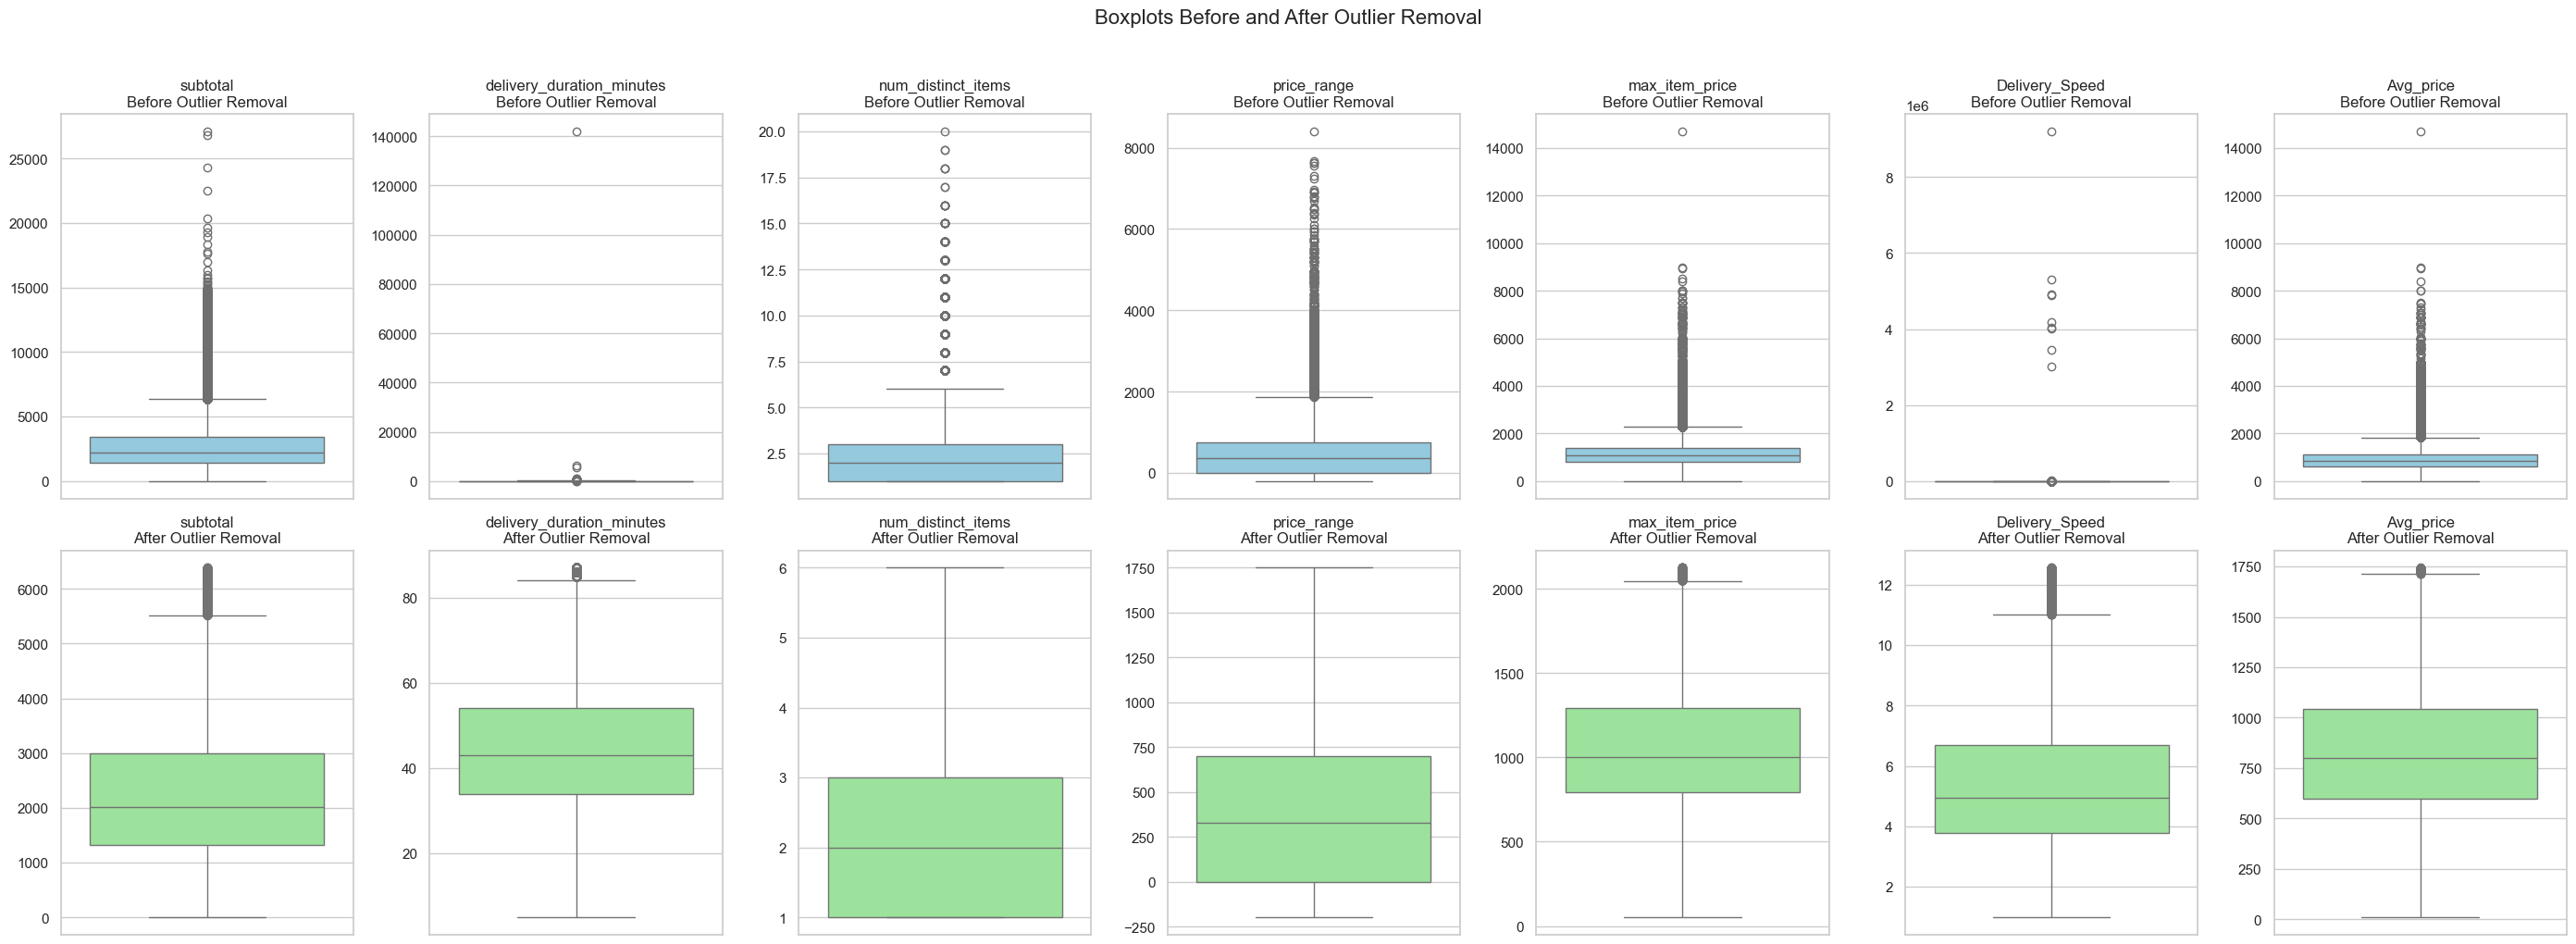

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
sns.set(style="whitegrid")
num_cols = len(outlier_columns)
fig, axes = plt.subplots(nrows=2, ncols=num_cols, figsize=(4 * num_cols, 10))

# Plot each column before and after outlier removal
for idx, col in enumerate(outlier_columns):
    # Boxplot BEFORE outlier removal
    sns.boxplot(y=data[col], ax=axes[0, idx], color='skyblue')
    axes[0, idx].set_title(f'{col}\nBefore Outlier Removal')
    axes[0, idx].set_ylabel("")
    
    # Boxplot AFTER outlier removal
    sns.boxplot(y=data_cleaned[col], ax=axes[1, idx], color='lightgreen')
    axes[1, idx].set_title(f'{col}\nAfter Outlier Removal')
    axes[1, idx].set_ylabel("")

# Set layout and show
plt.suptitle("Boxplots Before and After Outlier Removal", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [20]:
# Step 1: Define features
features = [
    'store_id_encoded', 'market_id_2.0',
       'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0',
       'order_protocol_2.0', 'order_protocol_3.0', 'order_protocol_4.0',
       'order_protocol_5.0', 'order_protocol_6.0', 'order_protocol_7.0',
    'total_items', 'subtotal', 'num_distinct_items',
    'min_item_price', 'max_item_price',
    'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
    'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration',
    'price_range', 'hour_of_day', 'day_of_week', 'month',
    'store_primary_category_encoded', 'dashers_per_order', 'orderPlaced_to_home_location_time', 'Avg_delivery_time',
        'Delivery_Speed',
        'Avg_price'
]

# Step 2: Select X and y
X = data_cleaned[features].copy()
y = data_cleaned['delivery_duration_minutes']

# Step 4: Scale numerical columns
numeric_cols = [
    'total_items', 'subtotal', 'num_distinct_items',
    'min_item_price', 'max_item_price',
    'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
    'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration',
    'price_range', 'hour_of_day', 'day_of_week', 'month',
    'dashers_per_order', 'orderPlaced_to_home_location_time', 'Avg_delivery_time',
        'Delivery_Speed',
        'Avg_price'
]
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Step 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, tree_method='gpu_hist' if xgb.get_config().get('use_gpu') else 'auto')
}

# Step 7: Train, predict, evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'MAE': round(mean_absolute_error(y_test, y_pred), 2),
        'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred)), 2),
        'R²': round(r2_score(y_test, y_pred), 4)
    }

# Step 8: Display results
print("\nModel Performance Comparison:")
for name, metrics in results.items():
    print(f"{name}: {metrics}")



Model Performance Comparison:
LinearRegression: {'MAE': 8.15, 'RMSE': 10.59, 'R²': 0.4561}
Ridge: {'MAE': 8.15, 'RMSE': 10.59, 'R²': 0.4561}
Random Forest: {'MAE': 8.04, 'RMSE': 10.49, 'R²': 0.4667}
XGBoost: {'MAE': 7.84, 'RMSE': 10.23, 'R²': 0.4926}


In [38]:
results = {
    'LinearRegression': {'MAE': 8.15, 'RMSE': 10.59, 'R²': 0.4561},
    'Ridge': {'MAE': 8.15, 'RMSE': 10.59, 'R²': 0.4561},
    'Random Forest': {'MAE': 8.04, 'RMSE': 10.49, 'R²': 0.4667},
    'XGBoost': {'MAE': 7.84, 'RMSE': 10.23, 'R²': 0.4926}
}

results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})

C:\Users\khach\AppData\Local\Temp\ipykernel_3588\1237665259.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='R²', palette='Greens_d')


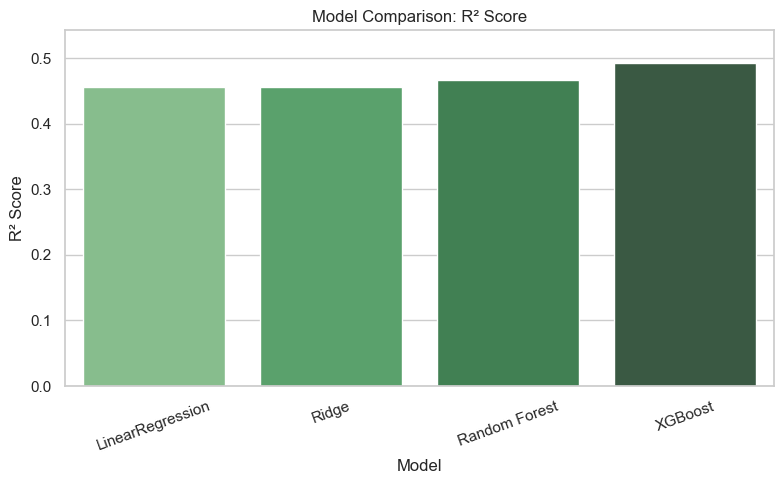

In [39]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='R²', palette='Greens_d')
plt.title("Model Comparison: R² Score")
plt.ylim(0, max(results_df['R²']) + 0.05)
plt.ylabel("R² Score")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

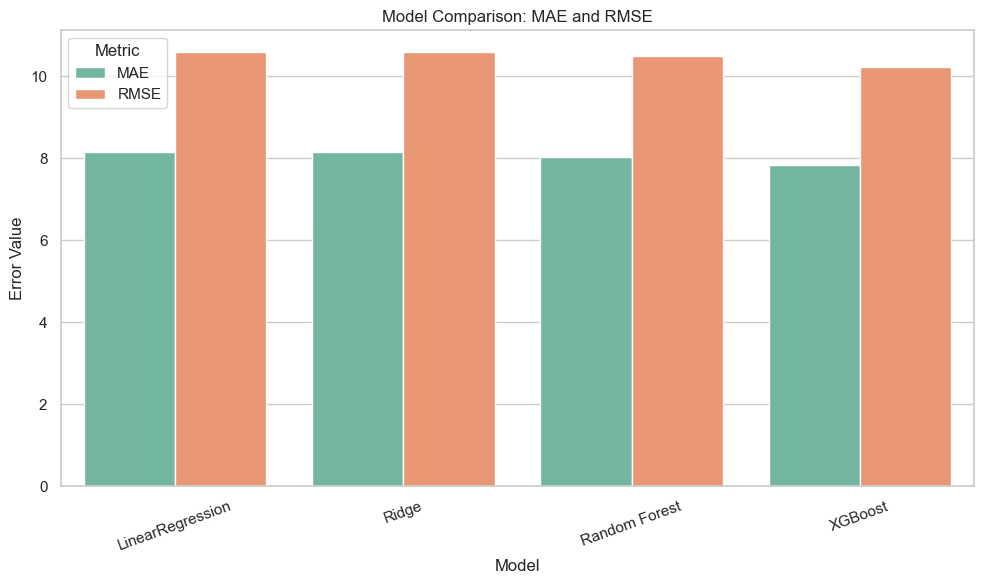

In [40]:
melted = results_df.melt(id_vars='Model', value_vars=['MAE', 'RMSE'], var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Model', y='Value', hue='Metric', palette='Set2')
plt.title("Model Comparison: MAE and RMSE")
plt.ylabel("Error Value")
plt.xticks(rotation=20)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

In [21]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2')
ridge_grid.fit(X_train, y_train)

ridge_best = ridge_grid.best_estimator_
y_pred = ridge_best.predict(X_test)

print("🔹 Ridge Regression")
print("Best Params:", ridge_grid.best_params_)
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))
print("R²:", round(r2_score(y_test, y_pred), 4))

cv_scores = cross_val_score(ridge_best, X_train, y_train, cv=5, scoring='r2')
print("CV R² Scores:", np.round(cv_scores, 4))
print("Mean CV R²:", round(np.mean(cv_scores), 4))

🔹 Ridge Regression
Best Params: {'alpha': 10}
MAE: 8.15
RMSE: 10.59
R²: 0.4561
CV R² Scores: [0.4648 0.4593 0.4586 0.4675 0.4671]
Mean CV R²: 0.4634


Ridge Regression model with an alpha value of 10 achieved an R² of 0.4561 on the test set, meaning it explains about 45.6% of the variation in delivery time. The average cross-validation R² across the training folds was 0.4634, showing stable and reliable performance. The MAE of 8.15 minutes suggests that the model's typical prediction error is around 8 minutes, with an RMSE of 10.59 indicating the presence of some larger deviations."

In [22]:
#Get feature names and coefficients
ridge_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge_best.coef_
})

#Add absolute value for ranking
ridge_coefficients['Abs_Coefficient'] = np.abs(ridge_coefficients['Coefficient'])

# Sort by importance
ridge_coefficients = ridge_coefficients.sort_values(by='Abs_Coefficient', ascending=False)

# Show top 10 features
print("Top 10 Most Influential Features (Ridge Regression):")
print(ridge_coefficients.head(10))

Top 10 Most Influential Features (Ridge Regression):
                                         Feature  Coefficient  Abs_Coefficient
19                      total_outstanding_orders    10.046452        10.046452
17                         total_onshift_dashers    -8.173627         8.173627
29                             Avg_delivery_time     7.203548         7.203548
8                             order_protocol_4.0     1.712460         1.712460
11                            order_protocol_7.0    -1.582693         1.582693
21  estimated_store_to_consumer_driving_duration     1.542833         1.542833
28             orderPlaced_to_home_location_time     1.401272         1.401272
10                            order_protocol_6.0     1.193026         1.193026
13                                      subtotal     1.152821         1.152821
3                                  market_id_4.0    -0.913353         0.913353


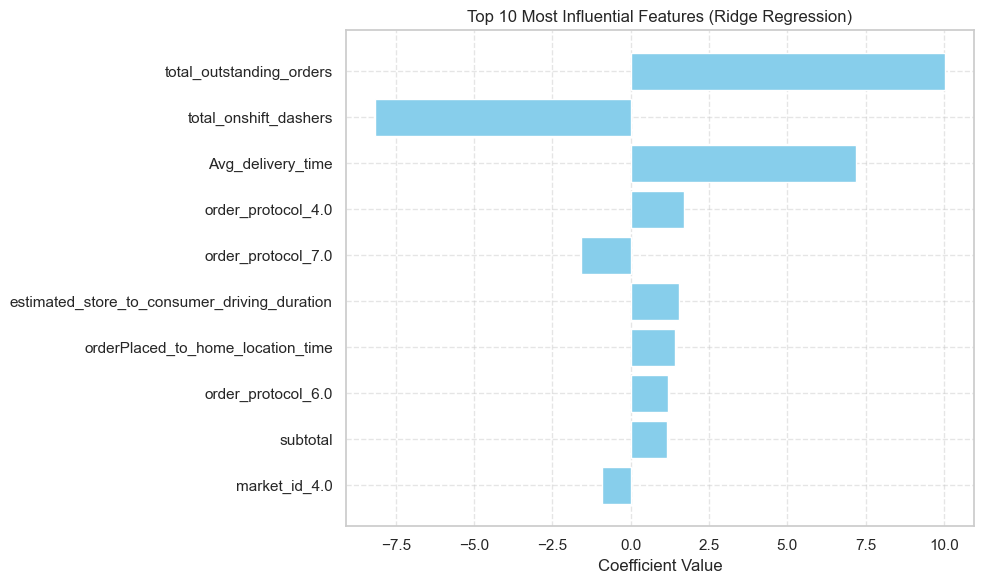

In [23]:
import matplotlib.pyplot as plt

# Select top 10 influential features
top_features = ridge_coefficients.head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
plt.xlabel("Coefficient Value")
plt.title("Top 10 Most Influential Features (Ridge Regression)")
plt.gca().invert_yaxis()  # So the highest is at the top
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [24]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

xgb_params = {
    'n_estimators': [100, 200, 300, 400],        # More trees = better learning (if not overfit)
    'learning_rate': [0.01, 0.05, 0.1, 0.2],     # Lower rates need more trees but generalize better
    'max_depth': [3, 5, 7, 9],                   # Deeper trees capture more complexity (risk: overfit)
    'subsample': [0.6, 0.8, 1.0],                # Lower = more regularization, faster training
    'colsample_bytree': [0.6, 0.8, 1.0],         # Same idea as above — randomly pick features
    'gamma': [0, 1, 5],                          # Adds split regularization — higher = more conservative
    'reg_alpha': [0, 0.01, 0.1, 1],              # L1 regularization
    'reg_lambda': [0.1, 1, 10]                   # L2 regularization
}
xgb_model = XGBRegressor(random_state=42, tree_method='hist') 
xgb_search = RandomizedSearchCV(xgb_model, xgb_params, n_iter=20, cv=5, scoring='r2', random_state=42)
xgb_search.fit(X_train, y_train)

# Evaluate
xgb_best = xgb_search.best_estimator_
y_pred = xgb_best.predict(X_test)

print("🔹 XGBoost (CPU Version)")
print("Best Params:", xgb_search.best_params_)
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))
print("R²:", round(r2_score(y_test, y_pred), 4))

cv_scores = cross_val_score(xgb_best, X_train, y_train, cv=5, scoring='r2')
print("CV R² Scores:", np.round(cv_scores, 4))
print("Mean CV R²:", round(np.mean(cv_scores), 4))

🔹 XGBoost (CPU Version)
Best Params: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 1.0}
MAE: 7.83
RMSE: 10.22
R²: 0.4938
CV R² Scores: [0.5025 0.4978 0.498  0.5048 0.5042]
Mean CV R²: 0.5015


In [25]:
import matplotlib.pyplot as plt

# 1. Get feature importance from the best model
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_best.feature_importances_
})

# 2. Sort by importance
xgb_importance = xgb_importance.sort_values(by='Importance', ascending=False)

# 3. View top 10 features
print("Top 10 Most Important Features (XGBoost):")
print(xgb_importance.head(10))

Top 10 Most Important Features (XGBoost):
                                         Feature  Importance
29                             Avg_delivery_time    0.527876
27                             dashers_per_order    0.081345
28             orderPlaced_to_home_location_time    0.055712
21  estimated_store_to_consumer_driving_duration    0.052282
24                                   day_of_week    0.026741
25                                         month    0.024188
13                                      subtotal    0.017727
23                                   hour_of_day    0.017112
8                             order_protocol_4.0    0.016141
14                            num_distinct_items    0.015986


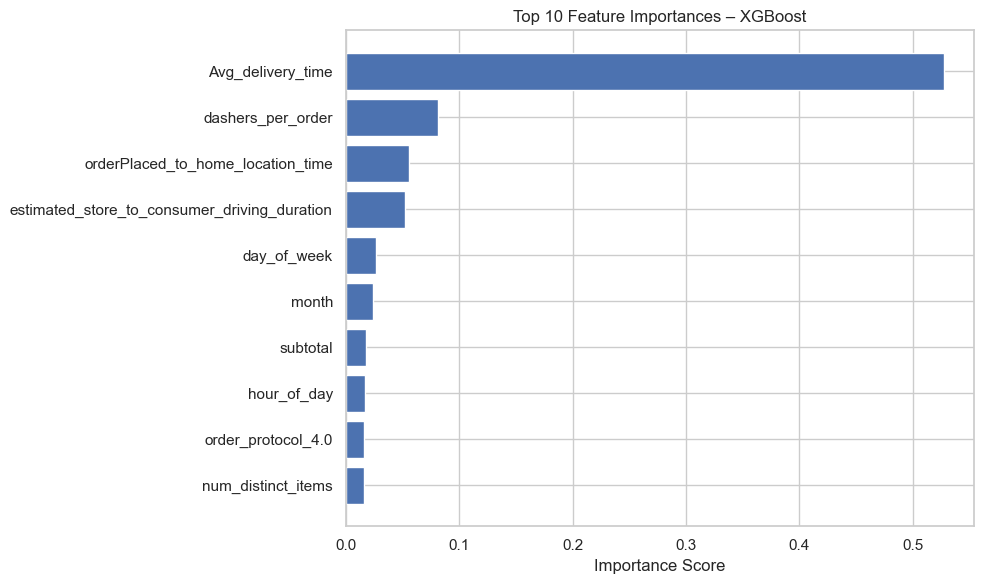

In [26]:
# Plot top 10
plt.figure(figsize=(10, 6))
plt.barh(xgb_importance['Feature'].head(10), xgb_importance['Importance'].head(10))
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Top 10 Feature Importances – XGBoost")
plt.tight_layout()
plt.show()

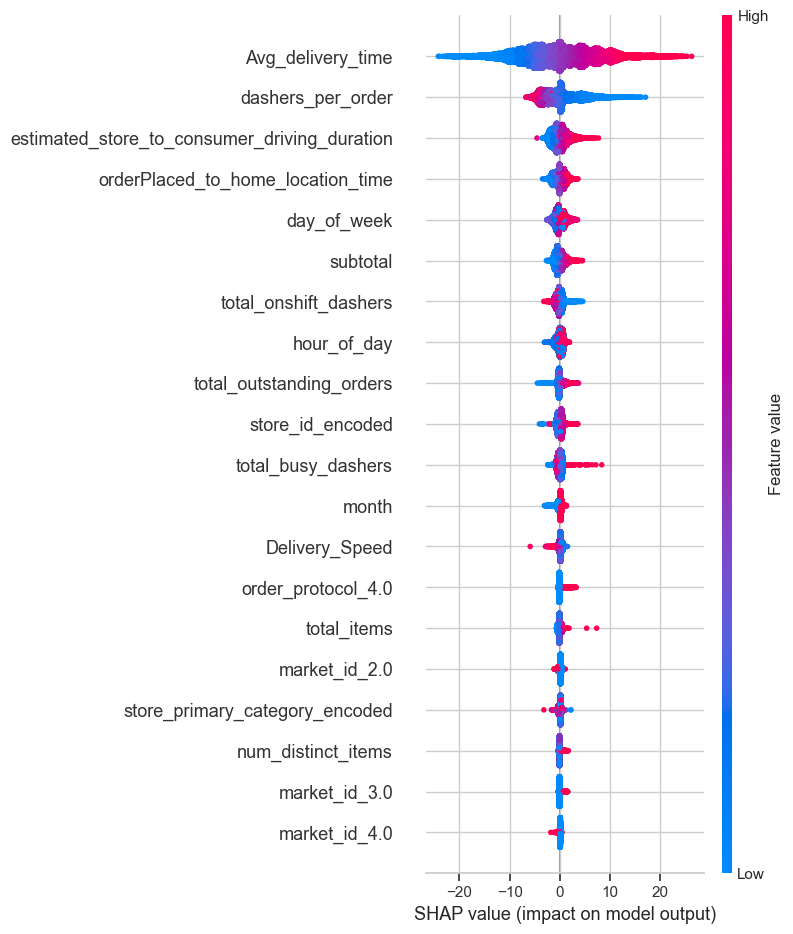

In [49]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Correct feature list with proper commas
features_used = [
     'store_id_encoded', 'market_id_2.0',
       'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0',
       'order_protocol_2.0', 'order_protocol_3.0', 'order_protocol_4.0',
       'order_protocol_5.0', 'order_protocol_6.0', 'order_protocol_7.0',
    'total_items', 'subtotal', 'num_distinct_items',
    'min_item_price', 'max_item_price',
    'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
    'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration',
    'price_range', 'hour_of_day', 'day_of_week', 'month',
    'store_primary_category_encoded', 'dashers_per_order', 'orderPlaced_to_home_location_time', 'Avg_delivery_time',
        'Delivery_Speed',
        'Avg_price'
]

# Step 2: Make sure your X_test matches these features
X_display = pd.DataFrame(X_test, columns=features_used)

# Step 3: SHAP explainer
explainer = shap.Explainer(xgb_best)

# Step 4: Compute SHAP values
shap_values = explainer(X_display)

# Step 5: Summary plot
shap.summary_plot(shap_values, X_display)

“The XGBoost model achieved a Mean Cross-Validation R² of 0.5015, indicating stable and consistent performance during training. The close match with the Test R² (0.4938) confirms the model’s ability to generalize well to unseen data.”

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'n_estimators': [100, 200, 300],         # more trees can improve accuracy
    'max_depth': [6, 10, 15],           # deeper trees, None = fully grown
    'min_samples_split': [5, 10],              # how many samples to split a node
    'min_samples_leaf': [2, 4],                # minimum samples per leaf
    'max_features': ['sqrt', 0.3, 0.5]   # how many features to consider at each split
    }
rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_params, n_iter=20, cv=5, scoring='r2', random_state=42, n_jobs=-1,
    verbose=1 )
rf_search.fit(X_train, y_train)

rf_best = rf_search.best_estimator_
y_pred = rf_best.predict(X_test)

print("🔹 Random Forest")
print("Best Params:", rf_search.best_params_)
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))
print("R²:", round(r2_score(y_test, y_pred), 4))

cv_scores = cross_val_score(rf_best, X_train, y_train, cv=5, scoring='r2')
print("CV R² Scores:", np.round(cv_scores, 4))
print("Mean CV R²:", round(np.mean(cv_scores), 4))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
🔹 Random Forest
Best Params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.3, 'max_depth': 15}
MAE: 7.94
RMSE: 10.35
R²: 0.4808
CV R² Scores: [0.4866 0.4826 0.4823 0.4901 0.4906]
Mean CV R²: 0.4865


In [28]:

# 1. Get feature importances from the best model
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_best.feature_importances_
})

# 2. Sort by importance
rf_importance = rf_importance.sort_values(by='Importance', ascending=False)

# 3. View top 10 features
print("Top 10 Most Important Features (Random Forest):")
print(rf_importance.head(10))

Top 10 Most Important Features (Random Forest):
                                         Feature  Importance
29                             Avg_delivery_time    0.392488
27                             dashers_per_order    0.139008
0                               store_id_encoded    0.077674
28             orderPlaced_to_home_location_time    0.060651
21  estimated_store_to_consumer_driving_duration    0.057854
30                                Delivery_Speed    0.040614
19                      total_outstanding_orders    0.028114
13                                      subtotal    0.027782
23                                   hour_of_day    0.024412
17                         total_onshift_dashers    0.019246


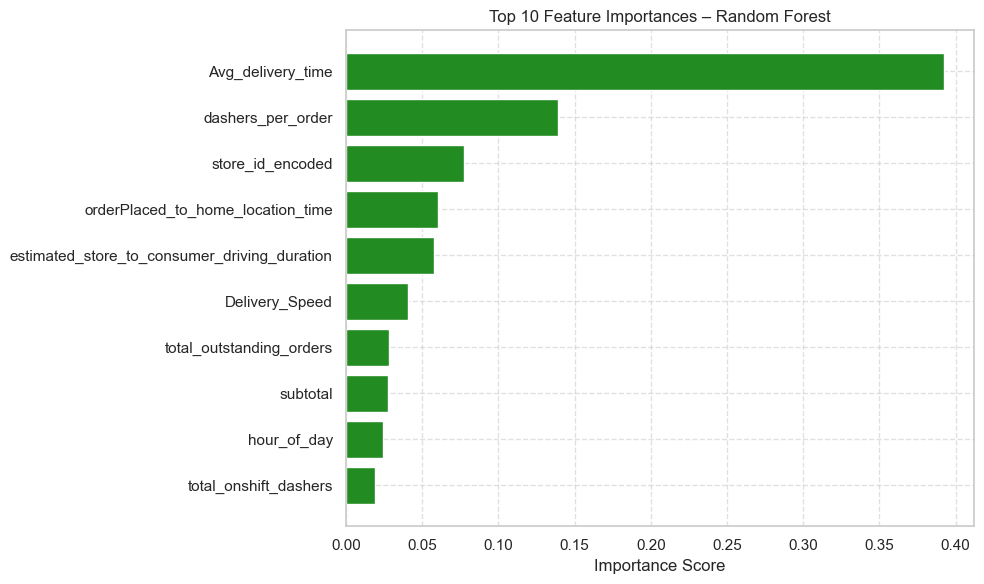

In [29]:
# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(rf_importance['Feature'].head(10), rf_importance['Importance'].head(10), color='forestgreen')
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Top 10 Feature Importances – Random Forest")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
import shap
import matplotlib.pyplot as plt

# Initialize the TreeExplainer with your trained XGBoost model
explainer = shap.Explainer(xgb_best)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot (feature impact across the whole dataset)
shap.summary_plot(shap_values, X_test)

In [ ]:
print(data_cleaned['delivery_duration_minutes'].describe())

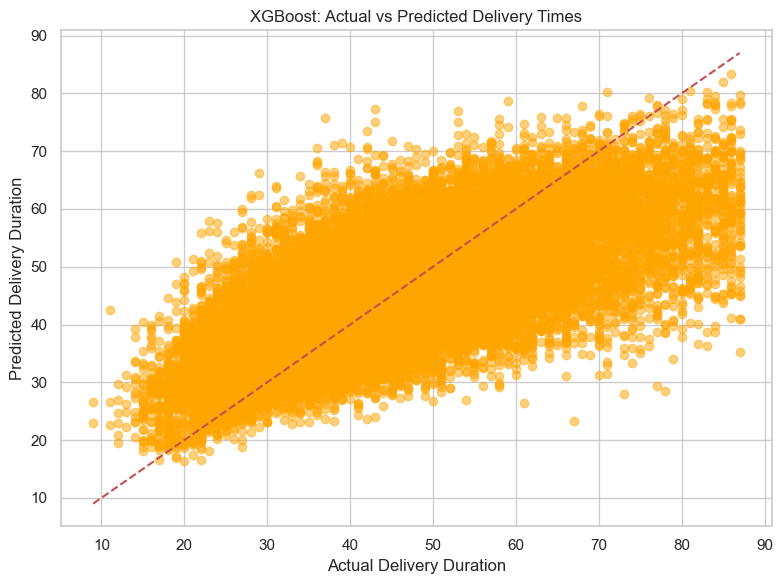

In [30]:
# 1. Predict using XGBoost
y_pred_xgb = xgb_best.predict(X_test)


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Delivery Duration")
plt.ylabel("Predicted Delivery Duration")
plt.title("XGBoost: Actual vs Predicted Delivery Times")
plt.tight_layout()
plt.show()

“This scatterplot compares XGBoost’s predicted delivery durations with actual values. The majority of predictions lie close to the red dashed line, indicating good alignment with reality. While predictions are highly accurate in the mid-range, the spread slightly increases for longer deliveries — likely due to variable factors such as traffic or dasher availability. Overall, the model performs well, with minimal outliers.”

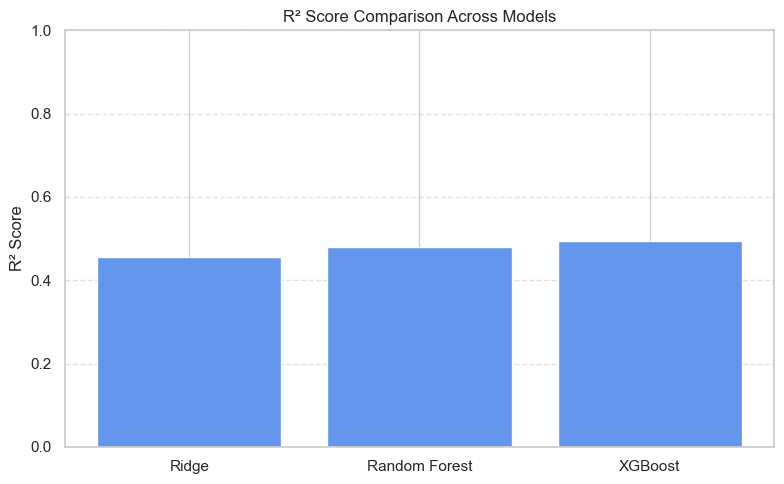

In [31]:
# R² Scores after hyper parameter tuning
models = ['Ridge', 'Random Forest', 'XGBoost']
r2_scores = [0.4561, 0.4808, 0.4938]

plt.figure(figsize=(8, 5))
plt.bar(models, r2_scores, color='cornflowerblue')
plt.title("R² Score Comparison Across Models")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

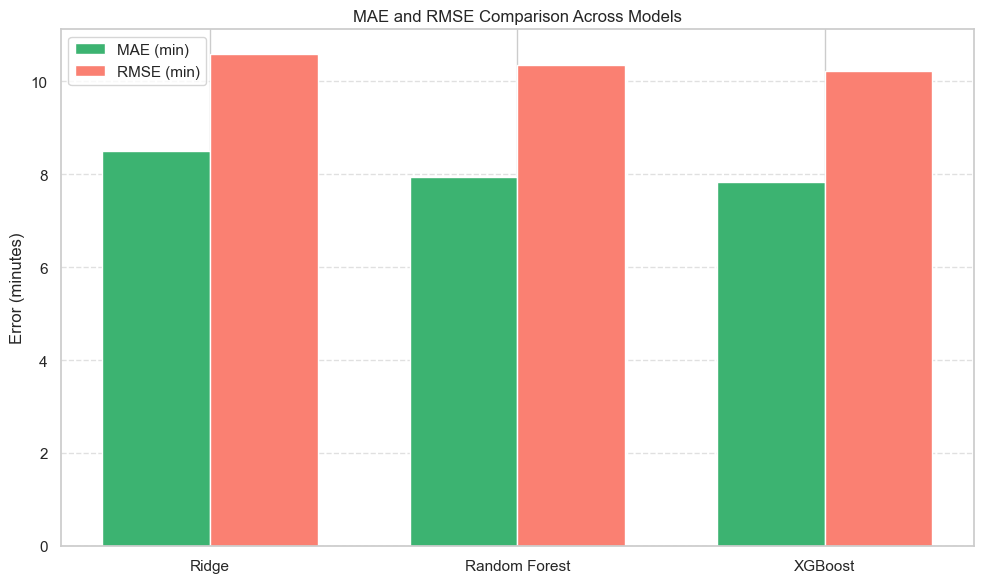

In [32]:
models = ['Ridge', 'Random Forest', 'XGBoost']
mae_values = [8.51, 7.94, 7.83]
rmse_values = [10.59, 10.35, 10.22]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, mae_values, width, label='MAE (min)', color='mediumseagreen')
plt.bar(x + width/2, rmse_values, width, label='RMSE (min)', color='salmon')

plt.xticks(x, models) 
plt.ylabel("Error (minutes)")
plt.title("MAE and RMSE Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()